# Hospital Readmission Prediction

This notebook implements a multi-modal machine learning framework for predicting critical patient outcomes in hospital settings, with a focus on readmissions.

## 1. Import Required Libraries and Modules

In [1]:
import sys
import os
# Add the project root directory to Python path
sys.path.append(os.path.abspath('..'))

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Import custom modules
from src.data.preprocessing import (
    load_data,
    clean_admissions_data,
    merge_patient_data,
    calculate_length_of_stay
)

from src.features.engineering import (
    create_temporal_features,
    create_patient_history_features,
    create_clinical_features,
    create_interaction_features
)

from src.visualization.plots import (
    plot_feature_distributions,
    plot_correlation_matrix,
    plot_feature_importance,
    plot_patient_trajectory,
    plot_model_performance
)

## 2. Load and Preprocess Data

In [3]:
# Define file paths
data_paths = {
    'admissions': '../../data/raw/admissions.csv.gz',
    'patients': '../../data/raw/patients.csv.gz',
    'diagnoses': '../../data/raw/diagnoses_icd.csv.gz',
    'procedures': '../../data/raw/procedures_icd.csv.gz',
    'icustays': '../../data/raw/icustays.csv.gz',
}

# Load data
data = load_data(data_paths)

# Clean and preprocess admissions data
admissions = clean_admissions_data(data['admissions'])

# Merge with patient data
admissions = merge_patient_data(admissions, data['patients'])

# Calculate length of stay
admissions = calculate_length_of_stay(admissions)

2025-05-20 10:29:43,572 - src.data.preprocessing - INFO - Successfully loaded admissions from ../../data/raw/admissions.csv.gz
2025-05-20 10:29:43,790 - src.data.preprocessing - INFO - Successfully loaded patients from ../../data/raw/patients.csv.gz
2025-05-20 10:29:47,000 - src.data.preprocessing - INFO - Successfully loaded diagnoses from ../../data/raw/diagnoses_icd.csv.gz
2025-05-20 10:29:47,705 - src.data.preprocessing - INFO - Successfully loaded procedures from ../../data/raw/procedures_icd.csv.gz
2025-05-20 10:29:47,971 - src.data.preprocessing - INFO - Successfully loaded icustays from ../../data/raw/icustays.csv.gz
2025-05-20 10:29:48,978 - src.data.preprocessing - INFO - Successfully cleaned admissions data
2025-05-20 10:29:49,168 - src.data.preprocessing - INFO - Successfully merged admissions and patient data
2025-05-20 10:29:49,346 - src.data.preprocessing - INFO - Successfully calculated length of stay


## 3. Feature Engineering

In [4]:
# Calculate Charlson Comorbidity Index
# Merge diagnoses and patient data to get age
diagnoses_cci = pd.merge(data['diagnoses'], data['patients'], on='subject_id', how='left')

# Rename the columns to match the comorbidity function's expected input
diagnoses_renamed = diagnoses_cci.rename(columns={'subject_id': 'id'})

# Calculate CCI scores
from comorbidipy import comorbidity

cci = comorbidity(
    diagnoses_renamed,
    id='id',
    code='icd_code',
    age='anchor_age',
    score='charlson',  
    assign0=True 
)

# Merge CCI scores with the admissions DataFrame
admissions = pd.merge(admissions, cci, left_on='subject_id', right_on='id', how='left')

# Rename the CCI score column for clarity
admissions = admissions.rename(columns={'comorbidity_score': 'charlson_index'})

In [5]:
# Create temporal features
admissions = create_temporal_features(admissions)

# Create patient history features
admissions = create_patient_history_features(admissions)

# Create clinical features
admissions = create_clinical_features(admissions, data['diagnoses'], data['procedures'])

# Create interaction features
admissions = create_interaction_features(admissions)

2025-05-20 10:30:16,877 - src.features.engineering - INFO - Successfully created temporal features
d:\Code\STW7048CEM_Computing_Individual_Research_Project\src\features\engineering.py:77: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['previous_los'].fillna(0, inplace=True)
d:\Code\STW7048CEM_Computing_Individual_Research_Project\src\features\engineering.py:78: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3

## 4.  Calculate Readmission Target

In [6]:
def calculate_readmission(admissions_df, readmission_window=30):
    admissions = admissions_df.copy()
    admissions['admittime'] = pd.to_datetime(admissions['admittime'], errors='coerce')
    admissions['dischtime'] = pd.to_datetime(admissions['dischtime'], errors='coerce')
    admissions = admissions.sort_values(by=['subject_id', 'admittime'])
    admissions['next_admittime'] = admissions.groupby('subject_id')['admittime'].shift(-1)
    admissions['time_to_readmission'] = (admissions['next_admittime'] - admissions['dischtime']).dt.days
    admissions['readmitted_within_30_days'] = (admissions['time_to_readmission'] > 0) & (admissions['time_to_readmission'] <= readmission_window)
    return admissions

admissions = calculate_readmission(admissions)

## 5. Data Visualization and Analysis

Available columns: ['subject_id', 'hadm_id', 'admittime', 'dischtime', 'deathtime', 'admission_type', 'admit_provider_id', 'admission_location', 'discharge_location', 'insurance', 'language', 'marital_status', 'race', 'edregtime', 'edouttime', 'hospital_expire_flag', 'gender', 'anchor_age_x', 'anchor_year', 'anchor_year_group', 'dod', 'los', 'id', 'anchor_age_y', 'aids', 'ami', 'canc', 'cevd', 'chf', 'copd', 'dementia', 'diab', 'diabwc', 'hp', 'metacanc', 'mld', 'msld', 'pud', 'pvd', 'rend', 'rheumd', 'charlson_index', 'age_adj_comorbidity_score', 'admit_dayofweek', 'admit_month', 'admit_season', 'admit_year', 'is_holiday', 'previous_admissions_count', 'previous_los', 'previous_dischtime', 'time_since_last_discharge', 'num_diagnoses', 'num_procedures', 'los_diagnoses_interaction', 'prev_adm_los_interaction', 'next_admittime', 'time_to_readmission', 'readmitted_within_30_days']


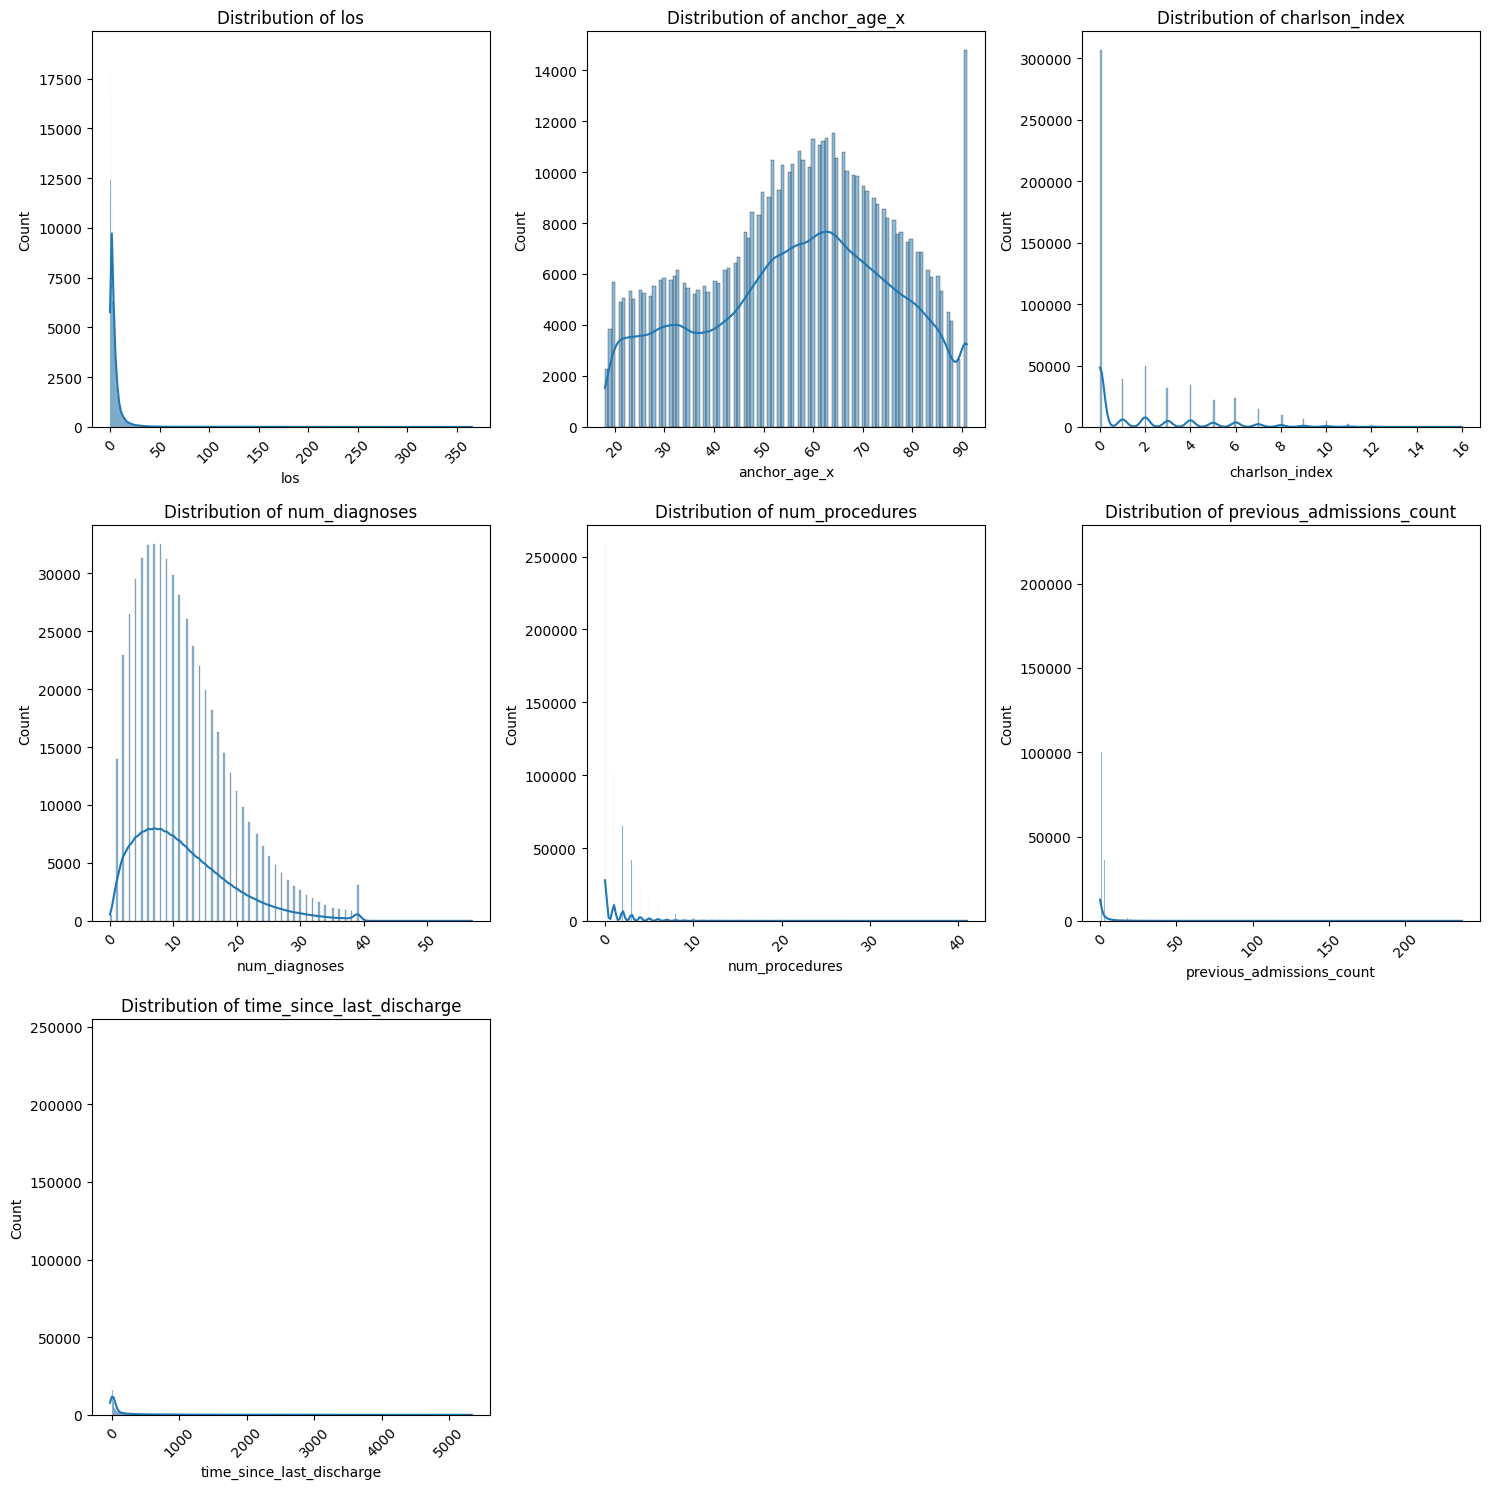

2025-05-20 10:30:52,737 - src.visualization.plots - INFO - Successfully plotted distributions for 7 features


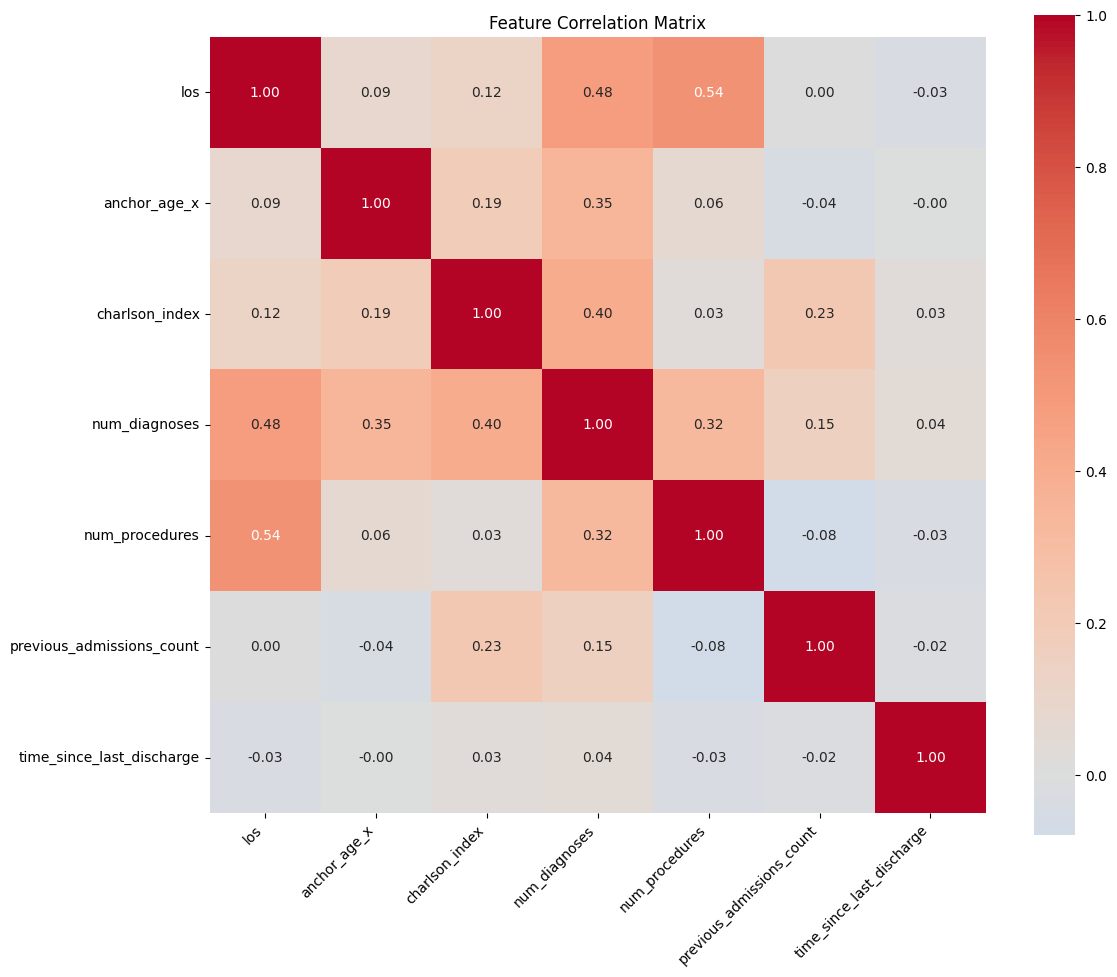

2025-05-20 10:30:53,173 - src.visualization.plots - INFO - Successfully plotted correlation matrix


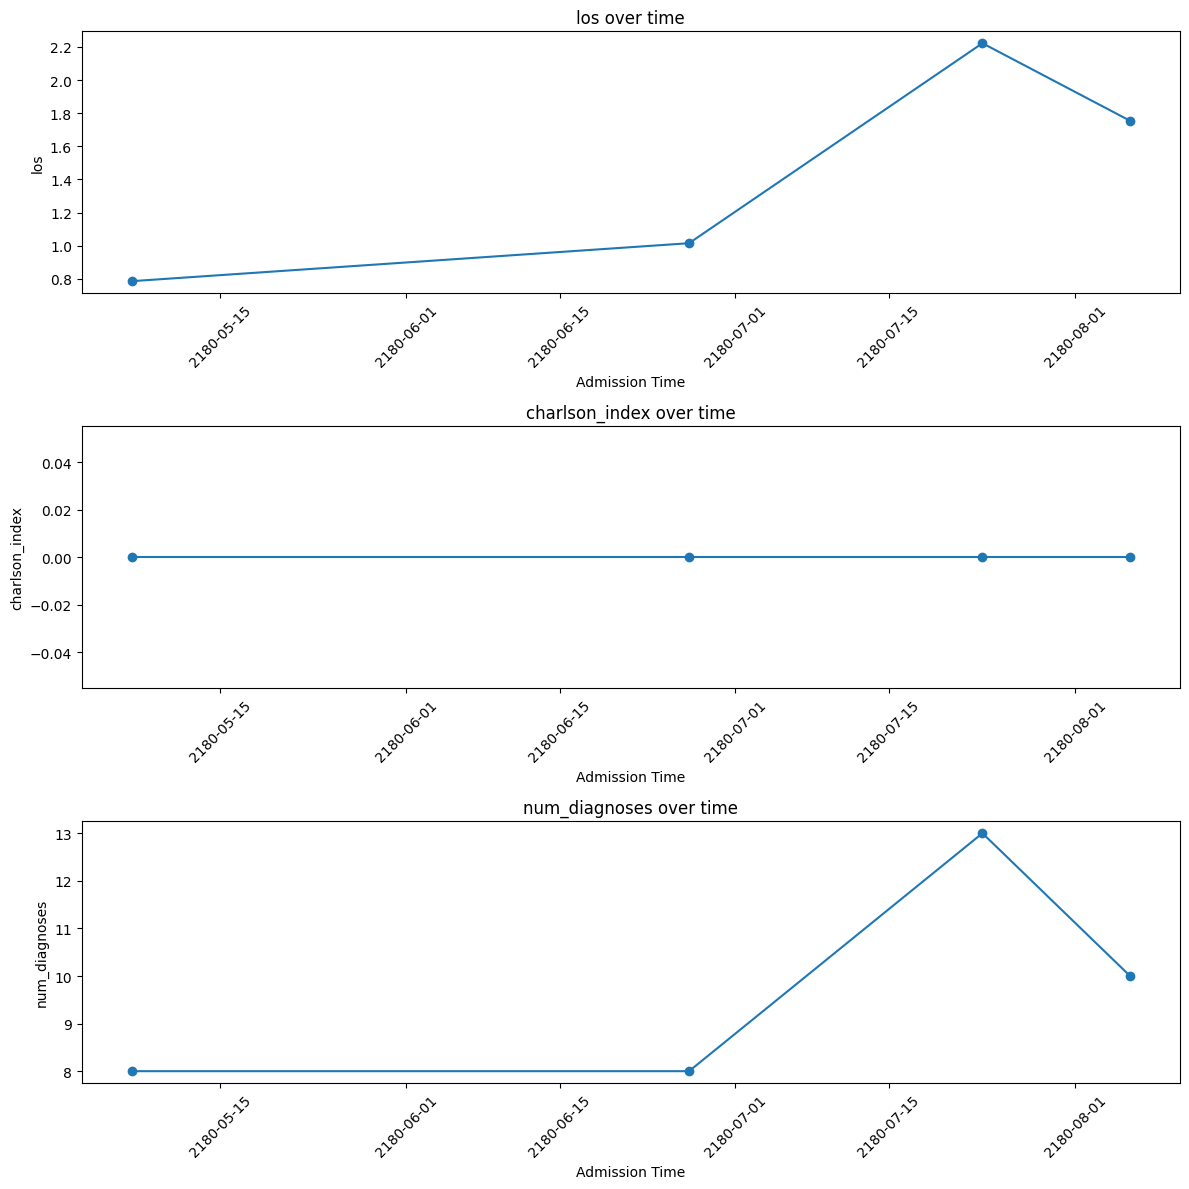

2025-05-20 10:30:53,710 - src.visualization.plots - INFO - Successfully plotted patient trajectory for patient 10000032


In [7]:
# Check available features
print("Available columns:", admissions.columns.tolist())

# Define features for visualization
numerical_features = [
    'los', 'anchor_age_x', 'charlson_index',
    'num_diagnoses', 'num_procedures',
    'previous_admissions_count', 'time_since_last_discharge'
]
available_features = [col for col in numerical_features if col in admissions.columns]

# Plot distributions and correlations
plot_feature_distributions(admissions, available_features)
plot_correlation_matrix(admissions, available_features)

# Example: Patient trajectory
features_to_plot = [col for col in ['los', 'charlson_index', 'num_diagnoses'] if col in admissions.columns]
if features_to_plot:
    patient_id = admissions['subject_id'].iloc[0]
    plot_patient_trajectory(admissions, patient_id, features_to_plot)

## 6. Prepare Data for Modeling

In [8]:
# Select features for modeling
feature_columns = [
    'los', 'anchor_age_x', 'charlson_index',
    'num_diagnoses', 'num_procedures',
    'previous_admissions_count', 'time_since_last_discharge',
    'admit_dayofweek', 'admit_month', 'admit_season',
    'is_holiday', 'previous_los',
    'age_charlson_interaction', 'los_diagnoses_interaction',
    'prev_adm_los_interaction'
]
available_features = [col for col in feature_columns if col in admissions.columns]
print("Features that will be used for modeling:", available_features)

# Prepare X and y
X = admissions[available_features].copy()
y = admissions['readmitted_within_30_days']

# Handle missing values
X = X.fillna(X.mean())

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Features that will be used for modeling: ['los', 'anchor_age_x', 'charlson_index', 'num_diagnoses', 'num_procedures', 'previous_admissions_count', 'time_since_last_discharge', 'admit_dayofweek', 'admit_month', 'admit_season', 'is_holiday', 'previous_los', 'los_diagnoses_interaction', 'prev_adm_los_interaction']


## 7. Apply SMOTE to Balance Classes

In [9]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
x_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

print("Original training set class distribution:")
print(y_train.value_counts())
print("\nResampled training set class distribution:")
print(pd.Series(y_train_resampled).value_counts())

Original training set class distribution:
readmitted_within_30_days
False    359336
True      77486
Name: count, dtype: int64

Resampled training set class distribution:
readmitted_within_30_days
False    359336
True     359336
Name: count, dtype: int64


## 8. Unified Model Evaluation Function

In [10]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve

all_model_results = {}

def evaluate_model(model, model_name, X_test_data, y_test_data, predict_proba_flag=True, display_plots=False):
    y_pred = model.predict(X_test_data)
    results = {
        'Accuracy': accuracy_score(y_test_data, y_pred),
        'Precision': precision_score(y_test_data, y_pred),
        'Recall': recall_score(y_test_data, y_pred),
        'F1-score': f1_score(y_test_data, y_pred),
    }
    if predict_proba_flag and hasattr(model, 'predict_proba'):
        y_pred_proba = model.predict_proba(X_test_data)[:, 1]
        results['AUC-ROC'] = roc_auc_score(y_test_data, y_pred_proba)
        if display_plots:
            fpr, tpr, thresholds = roc_curve(y_test_data, y_pred_proba)
            plt.figure(figsize=(8, 6))
            plt.plot(fpr, tpr, label=f'AUC = {results["AUC-ROC"]:.4f}')
            plt.plot([0, 1], [0, 1], 'k--')
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate (Recall)')
            plt.title(f'ROC Curve - {model_name}')
            plt.legend()
            plt.show()
    elif predict_proba_flag:
        print(f"Warning: {model_name} does not have predict_proba method. AUC-ROC will not be calculated.")

    all_model_results[model_name] = results
    print(f"\n{model_name} Performance:")
    for metric, score in results.items():
        print(f"  {metric}: {score:.4f}")
    print("-" * 30)

    if display_plots:
        cm = confusion_matrix(y_test_data, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['Not Readmitted', 'Readmitted'],
                    yticklabels=['Not Readmitted', 'Readmitted'])
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title(f'Confusion Matrix - {model_name}')
        plt.show()

## 9. Train and Evaluate Multiple Models

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.neural_network import MLPClassifier

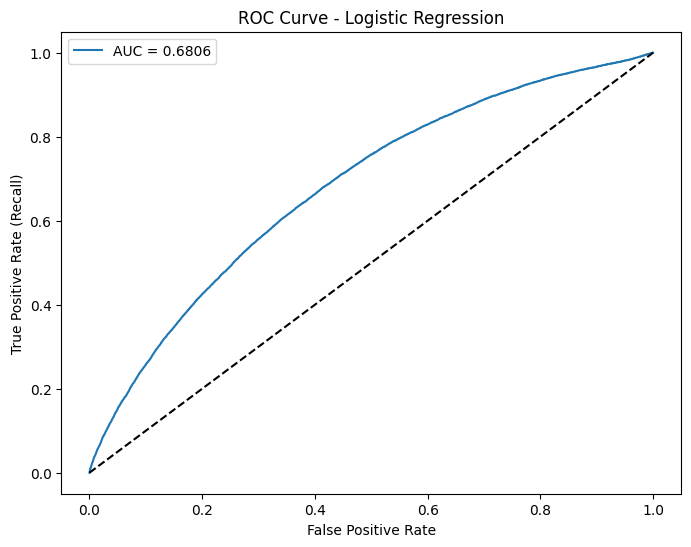


Logistic Regression Performance:
  Accuracy: 0.6726
  Precision: 0.2849
  Recall: 0.5597
  F1-score: 0.3776
  AUC-ROC: 0.6806
------------------------------


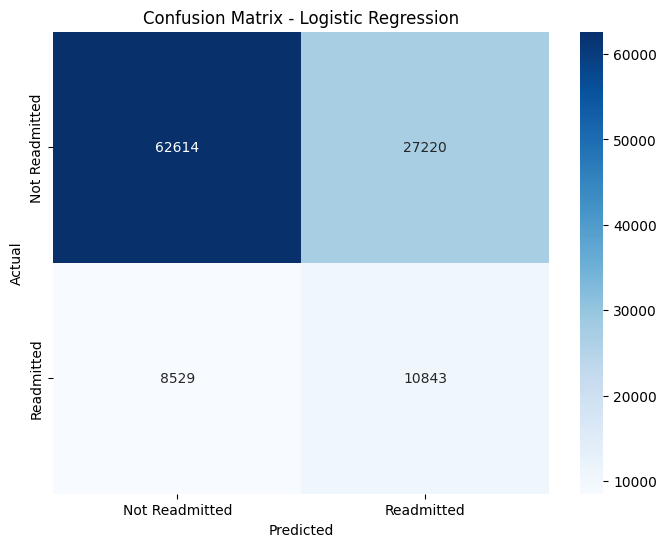

In [12]:
# Logistic Regression
logistic_model = LogisticRegression(random_state=42, solver='liblinear', class_weight='balanced', max_iter=1000)
logistic_model.fit(x_train_resampled, y_train_resampled)
evaluate_model(logistic_model, 'Logistic Regression', X_test_scaled, y_test, display_plots=True)

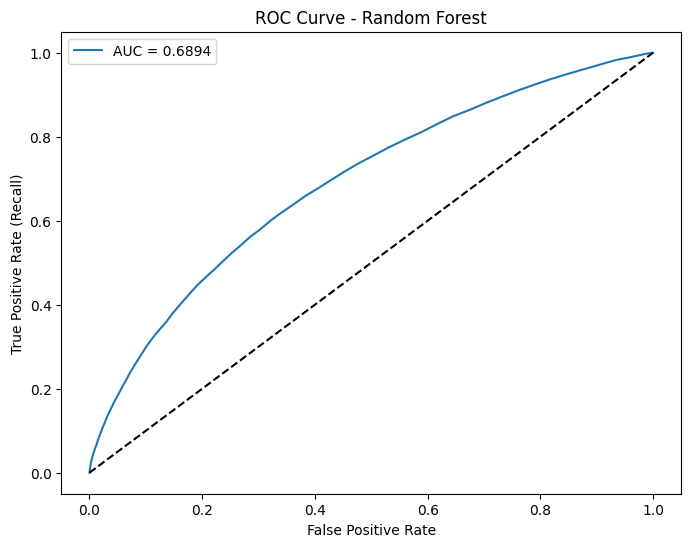


Random Forest Performance:
  Accuracy: 0.8079
  Precision: 0.4215
  Recall: 0.2228
  F1-score: 0.2915
  AUC-ROC: 0.6894
------------------------------


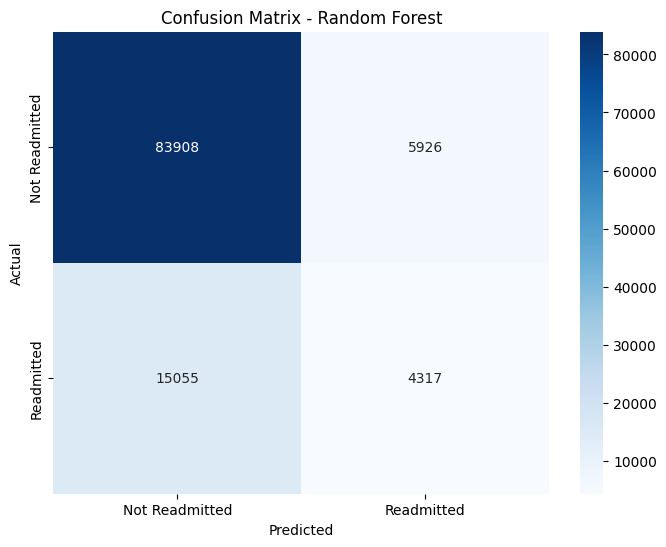

In [13]:
# Random Forest
random_forest_model = RandomForestClassifier(random_state=42, class_weight='balanced')
random_forest_model.fit(x_train_resampled, y_train_resampled)
evaluate_model(random_forest_model, 'Random Forest', X_test_scaled, y_test, display_plots=True)

d:\PythonInstallation\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:43:15] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


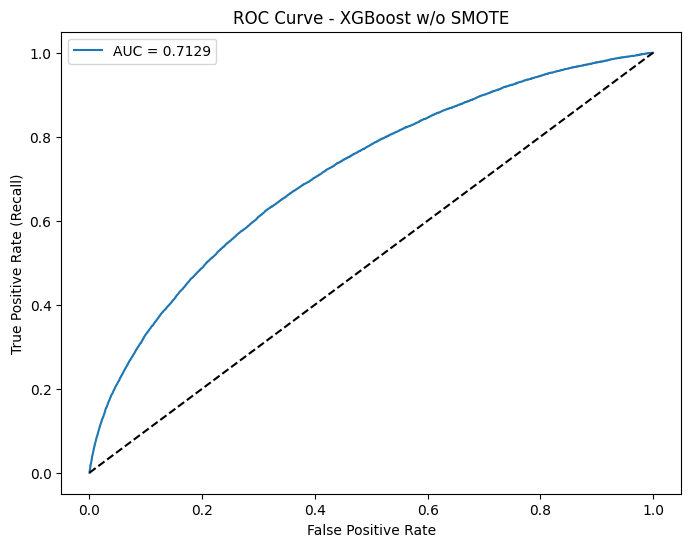


XGBoost w/o SMOTE Performance:
  Accuracy: 0.6818
  Precision: 0.3035
  Recall: 0.6130
  F1-score: 0.4060
  AUC-ROC: 0.7129
------------------------------


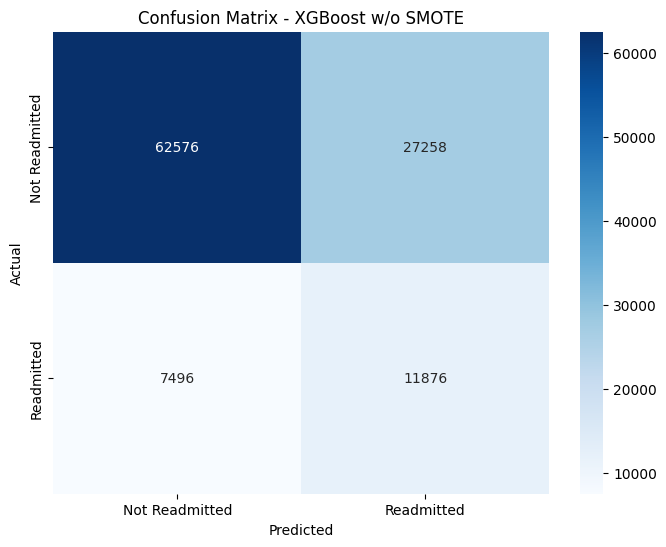

In [24]:
# XGBoost without sSMOTE
xgb_model_wo_SMOTE = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss', scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum())
xgb_model_wo_SMOTE.fit(X_train, y_train)
evaluate_model(xgb_model_wo_SMOTE, 'XGBoost w/o SMOTE', X_test, y_test, display_plots=True)

d:\PythonInstallation\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:37:41] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


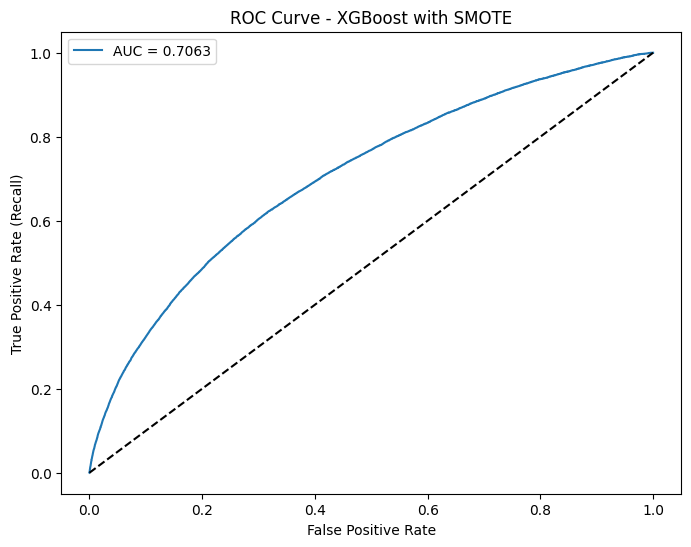


XGBoost with SMOTE Performance:
  Accuracy: 0.8251
  Precision: 0.5283
  Recall: 0.1299
  F1-score: 0.2085
  AUC-ROC: 0.7063
------------------------------


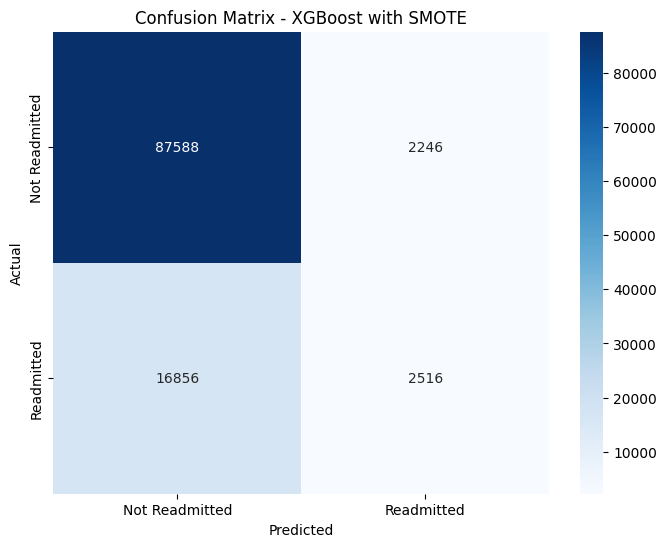

In [15]:
# XGBoost with sSMOTE
xgb_model_w_SMOTE = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_model_w_SMOTE.fit(x_train_resampled, y_train_resampled)
evaluate_model(xgb_model_w_SMOTE, 'XGBoost with SMOTE', X_test_scaled, y_test, display_plots=True)

[LightGBM] [Info] Number of positive: 77486, number of negative: 359336
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002970 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1617
[LightGBM] [Info] Number of data points in the train set: 436822, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.177386 -> initscore=-1.534161
[LightGBM] [Info] Start training from score -1.534161


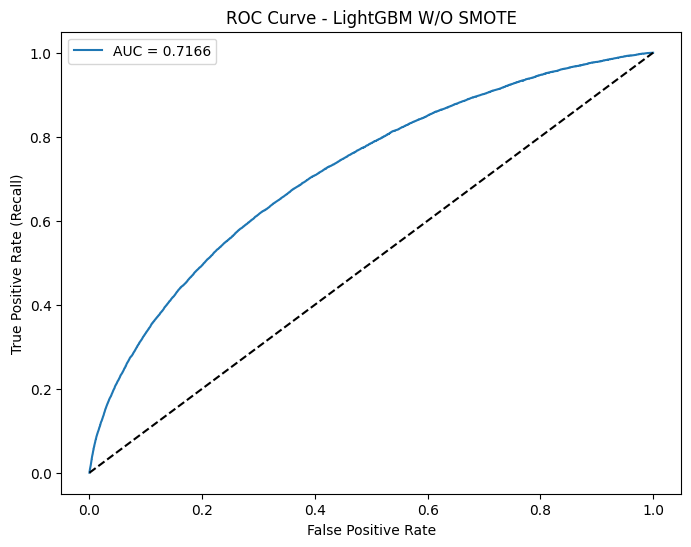


LightGBM W/O SMOTE Performance:
  Accuracy: 0.6785
  Precision: 0.3029
  Recall: 0.6242
  F1-score: 0.4079
  AUC-ROC: 0.7166
------------------------------


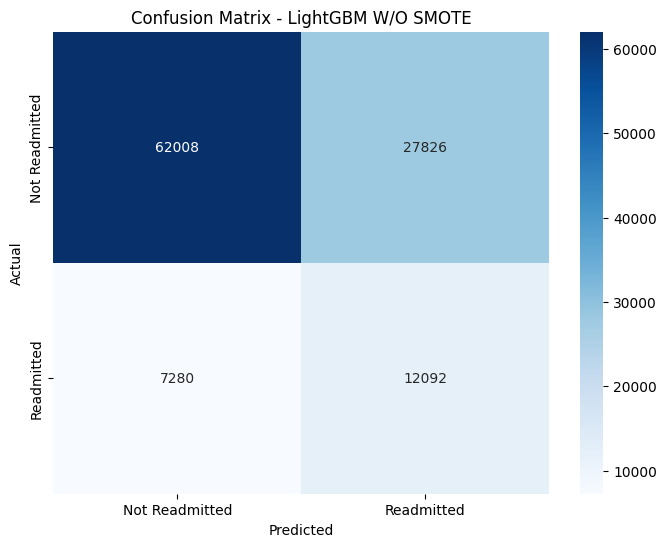

In [22]:
# LightGBM without SMOTE
lgbm_model_wot_SMOTE = lgb.LGBMClassifier(random_state=42, objective='binary', is_unbalance=True)
lgbm_model_wot_SMOTE.fit(X_train, y_train)
evaluate_model(lgbm_model_wot_SMOTE, 'LightGBM W/O SMOTE', X_test, y_test, display_plots=True)

[LightGBM] [Info] Number of positive: 359336, number of negative: 359336
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005933 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3370
[LightGBM] [Info] Number of data points in the train set: 718672, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


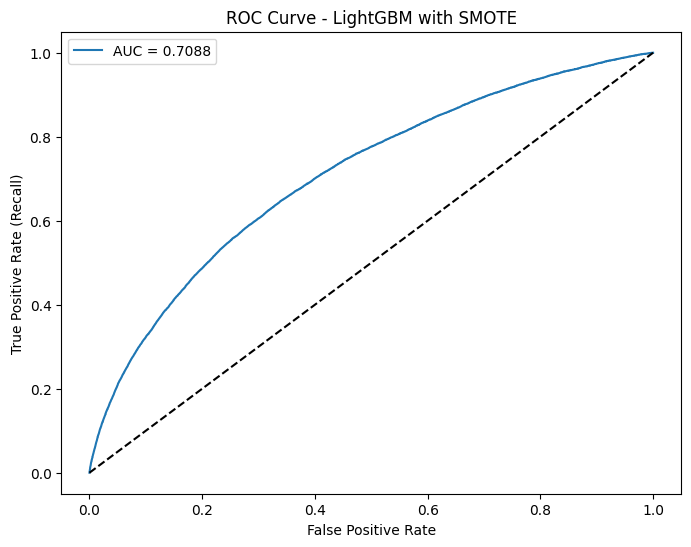


LightGBM with SMOTE Performance:
  Accuracy: 0.8244
  Precision: 0.5197
  Recall: 0.1323
  F1-score: 0.2109
  AUC-ROC: 0.7088
------------------------------


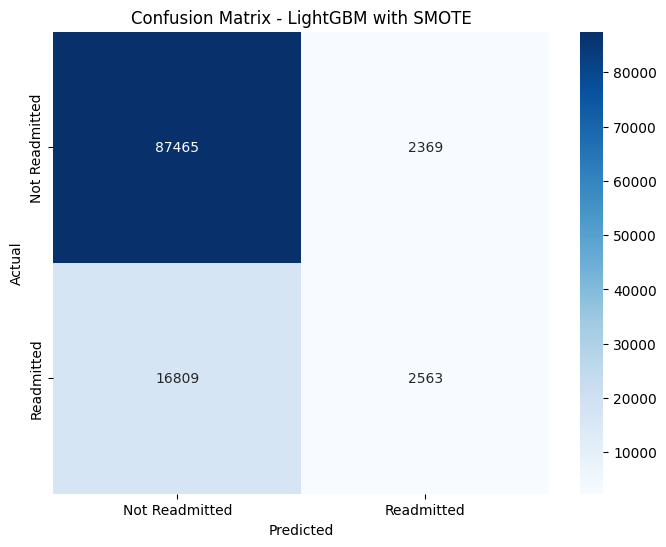

In [17]:
# LightGBM with SMOTE
lgbm_model_w_SMOTE = lgb.LGBMClassifier(random_state=42, objective='binary', is_unbalance=True)
lgbm_model_w_SMOTE.fit(x_train_resampled, y_train_resampled)
evaluate_model(lgbm_model_w_SMOTE, 'LightGBM with SMOTE', X_test_scaled, y_test, display_plots=True)

d:\PythonInstallation\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


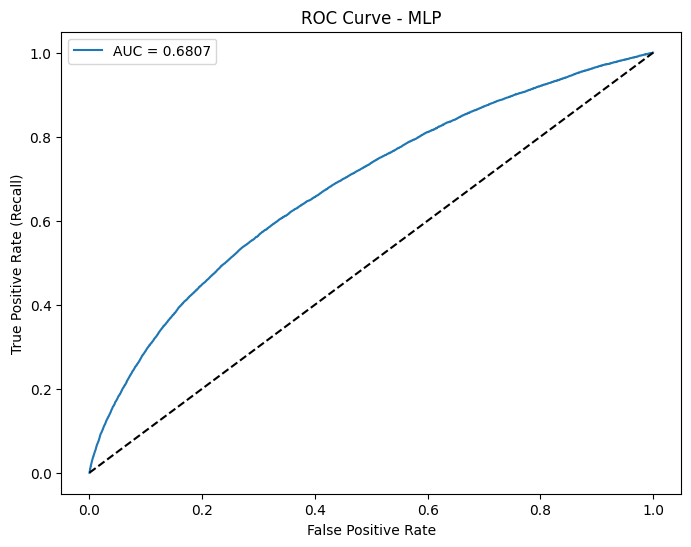


MLP Performance:
  Accuracy: 0.8052
  Precision: 0.4109
  Recall: 0.2263
  F1-score: 0.2919
  AUC-ROC: 0.6807
------------------------------


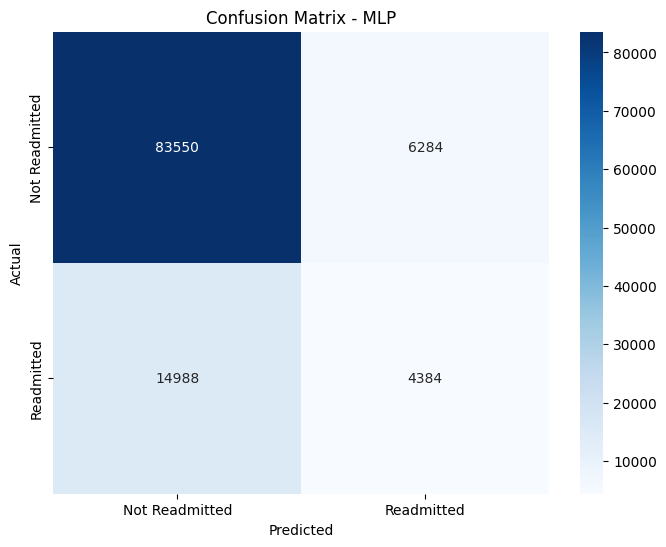

In [26]:
# MLP (Neural Network)
mlp_model = MLPClassifier(random_state=42, max_iter=300, hidden_layer_sizes=(64, 32), activation='relu', solver='adam')
mlp_model.fit(x_train_resampled, y_train_resampled)
evaluate_model(mlp_model, 'MLP', X_test_scaled, y_test, display_plots=True)

## 10. Model Performance Comparison Heatmap


--- Model Evaluation Summary (Heatmap) ---


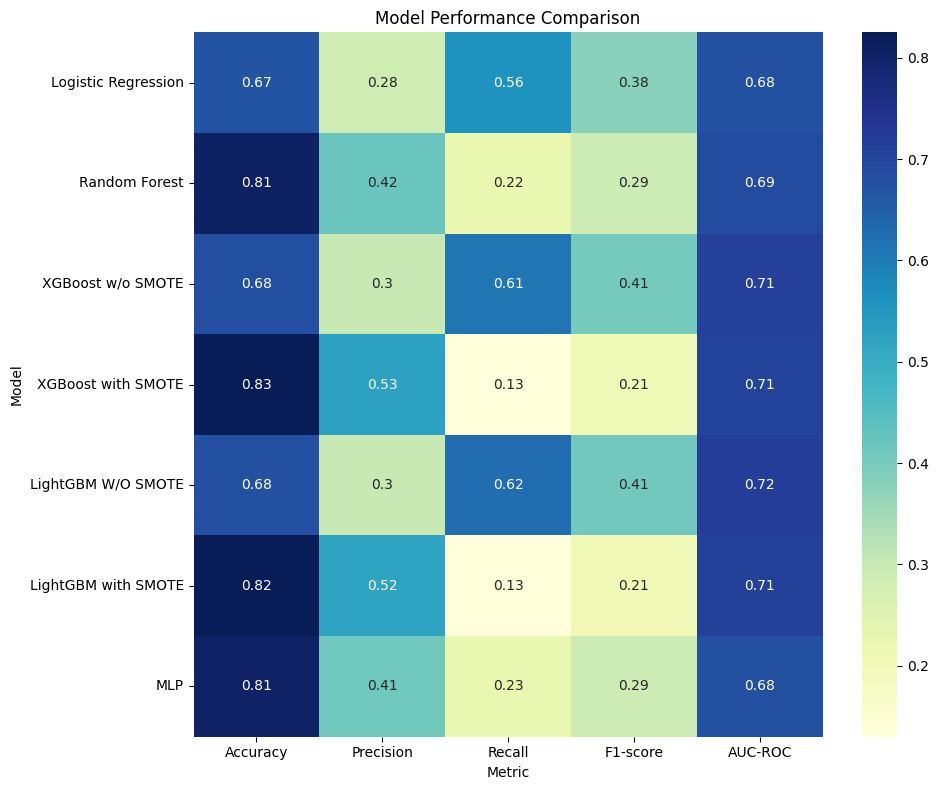

In [27]:
import pandas as pd

print("\n--- Model Evaluation Summary (Heatmap) ---")
model_names = list(all_model_results.keys())
metrics = list(all_model_results[model_names[0]].keys())
performance_matrix = []

for model in model_names:
    performance_matrix.append([all_model_results[model][metric] for metric in metrics])

performance_df = pd.DataFrame(performance_matrix, index=model_names, columns=metrics)

plt.figure(figsize=(10, 8))
sns.heatmap(performance_df, annot=True, cmap='YlGnBu')
plt.title('Model Performance Comparison')
plt.ylabel('Model')
plt.xlabel('Metric')
plt.tight_layout()
plt.show()

In [28]:
# Summarize findings, export results, or save models as needed
performance_df.to_csv('model_performance_summary.csv')